# Exercise Sheet 4 - Optimization 2

Welcome to the first programming exercise.

The programming homeworks are designed in a way that you will (a) gain a deeper understanding of the content discussed in the lecture, and (b) become familiar with [PyTorch](https://pytorch.org/), a common Python framework for implementing neural networks.

Generally they will consist of a Jupyter notebook, accompanied with a `utils.py` file for utility functions, and optionally a dataset as a `.zip` or `.tar.gz` file. In the notebook there will be areas where you will have to write your own code. These areas are highlighted using comments. Do not change anything else in the notebook. If you feel there are mistakes or things that need to be changed or are unsure, use the Discussion forum in ISIS.

We will assume that you have Python >= 3.9 and PyTorch 2.X installed on your machine.

# Dataset (MNIST)

PyTorch offers various utility functions and classes for easing the process of managing datasets. Additionally to offering various standard datasets being loaded using built-in functions through the `torchvision` package, the most frequently used classes are probably the `Dataset` and `DataLoader` class, both included in the `torch.utils.data` module. The classes can be used to create own custom datasets which can then be easily integrated into standard training procedures.

In this exercise we will use the built-in [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset. For that you will have to install the [torchvision](https://pypi.org/project/torchvision/) package if not already installed.

If you are interested how PyTorch datasets work internally, we recommend taking a look at [this guide](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files).

The `Dataset` class defines how to get the i-th item. For example, you could load your whole dataset into an array, and then simply retrieve the i-th row. Or if the dataset is too big, which is usually the case in deep learning settings, you might just store the path to your dataset files as a class variable, and then retrieve the i-th file using Python's built-in I/O function.

The `DataLoader` class takes an input of type `Dataset`, along with various parameters on how that data set should be loaded. Most commonly you will set the batch size and whether the data should be shuffled or not.

Tensor dimension of a single batch
(batch_size x channels x height x width): [32, 1, 28, 28]


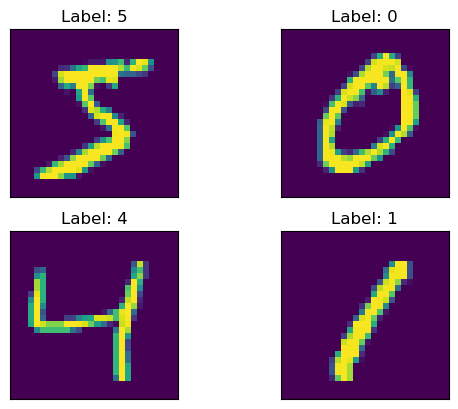

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from utils import *

# --------------------------------------------------
# TODO: Remove this line
# --------------------------------------------------
#from solution import *
# --------------------------------------------------

"""
Here we fetch the dataset. The `root` param defines where on your disk to put
it (in this case in a directory called 'root' that will be created if not
already there), and the `download` param tells PyTorch to download it if
necessary. The `transform` param specifies what should be done with the images
after they were fetched from the disk. In some cases you might want to apply
data augmentations, for example additionally rotate our images.
For this exercise we will simply convert it into a `torch.Tensor` object so we
can feed it into our model. To the test set we additionally pass the
`train`=False param to indicate that we want the test split.
"""
train_set = datasets.MNIST(root="data", download=True, transform=ToTensor())
test_set = datasets.MNIST(root="data",
                          download=True,
                          transform=ToTensor(),
                          train=False)
"""
As described above, the DataLoader class specifies how to load the data. Here
we have specified a batch size of 64. Usually, for
the train set the shuffle parameter is set to True, meaning that the dataloader
iterates through the dataset in random order each time. We won't shuffle the
train set in this exercise because we want to train multiple models under
similar conditions and compare the results. The test set isn't
shuffled, because that way we can easily access the same samples which eases the
comparison of models and their predictions.
"""
train_loader = DataLoader(train_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
"""
These lines of code simply start iterating through the dataloader, visualize
the first 4 images of the first batch, and then terminate the iteration.
"""
for batch, labels in train_loader:
    print(
        """Tensor dimension of a single batch
(batch_size x channels x height x width):""", list(batch.shape))
    visualize_first_4(batch, labels)
    break

# Models

Next we will take a look at how we can specify the architecture of our neural network (in deep learning our model almost always will be a neural network). The base class of all neural networks in PyTorch is the `torch.nn.Module` class. Every component of a neural network inherits from this class and the final neural network as well. Next is an example of how one could write an MLP (Multi-layer Perceptron a.k.a. Fully connected neural network) of fixed size in PyTorch. A class inheriting from `nn.Module` has to specify 2 functions:
- `__init__()`: here we define all components and parameters of the model, as well as any configuration variables that may be used to alter how the network works.
- `forward()`: here specify the forward pass by making use of the components that we have instantiated in the `__init__()` function.

In [2]:
from torch import nn


class SimpleFixedMLP(nn.Module):

    def __init__(self):
        """
        Here we define the components that we will use in the forward pass of
        our model. As you can see we use the `nn.Linear` module with the bias
        parameter set to true. It simply defines a matrix multiplication
        y = Wx + b, which corresponds to one layer of an MLP without the
        activation function applied. We have one input layer that takes as input
        the flattened images, which have width and height of 28 pixels, and maps
        it to a 32-dimensional feature vector. Then we have two hidden layers
        that transform the features, keeping the dimensionality of 32. The
        output layer takes the final 32 features and maps them into a 10
        dimensional vector, where the index of highest entry indicates the
        predicted class. Digits 0 to 9 equal 10 classes.
        The activation function is set to be the ReLU function, which simply
        sets negative values to zero, and keeps positive values the same.

        The `nn.Flatten` layer in the beginning simply flattens our images
        except for the batch dimension.
        E.g. from (BS x C x H x W) -> (BS x C*H*W)

        You may wonder why we only have specified the activation module once,
        although its being used at 3 different locations, and the hidden layers
        are instantiated separately, although they are instantiated with
        identical parameters. This is simply because the ReLU activation
        function doesnt have any internal parameters, it just sets negative
        values to zero. The linear layers on the other hand depend on the weight
        matrix W. Thus, reusing the same linear layer would theoretically work,
        but we wouldnt learn distinct mappings.
        """
        super().__init__()
        self.flatten = nn.Flatten()
        self.input_layer = nn.Linear(in_features=28 * 28,
                                     out_features=32,
                                     bias=True)
        self.hidden_layer1 = nn.Linear(in_features=32,
                                       out_features=32,
                                       bias=True)
        self.hidden_layer2 = nn.Linear(in_features=32,
                                       out_features=32,
                                       bias=True)
        self.output_layer = nn.Linear(in_features=32,
                                      out_features=10,
                                      bias=True)
        self.activation = nn.ReLU()

    def forward(self, input):
        """
        This is the forward pass. It takes as an argument the input to the model
        and returns the input after applying the components.
        """
        out = self.flatten(input)
        out = self.input_layer(out)
        out = self.activation(out)
        out = self.hidden_layer1(out)
        out = self.activation(out)
        out = self.hidden_layer2(out)
        out = self.activation(out)
        out = self.output_layer(out)
        return out

## Task 1a (20 P)
Write another class `SimpleMLP`, that takes as an argument a list of dimensionalities of the layers, such that we can instantiate MLPs of arbitrary size using that class. If we'd like to replicate the above SimpleFixedMLP we could set the `dims` parameter to `[28*28, 32, 32, 32, 10]`. The activation function should remain the ReLU function. Also don't be confused by how the solution may look like, you don't have to put
all the layers into a single variable.

It's very important for all the variables defined in your `__init__()` function to be either a subclass of `nn.Module` (most members of the `torch.nn` package inherit from `torch.nn.Module`) or to be wrapped with `nn.Parameter(...)`. This is because otherwise, when training our model, these variables may not be considered "learnable" and won't change. Furthermore, when saving the model to a file, PyTorch only saves variables that it recognizes as parameters. These resources may help: [a blog post](https://blog.paperspace.com/pytorch-101-advanced/), [stackoverflow question](https://stackoverflow.com/questions/50935345/understanding-torch-nn-parameter) or [pytorch nn.Parameter docs](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html)  

Hint: you may use the [`ModuleList`](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html) module.

In [3]:
class SimpleMLP(nn.Module):

    def __init__(self, dims: list[int]):
        super().__init__()

        # --------------------------------------------------
        # TODO: Replace by your code
        # --------------------------------------------------
        self.flatten = nn.Flatten()
        self.layer = nn.ModuleList()
        
        for i in range(len(dims) - 1):
            self.layer.append(nn.Linear(dims[i],dims[i+1]))
            if i < len(dims) - 2:
                self.layer.append(nn.ReLU())
                
        #for param in self.parameters():
        #    param.requires_grad = True

            
        # --------------------------------------------------

    def forward(self, input: torch.Tensor):

        # --------------------------------------------------
        # TODO: Replace by your code
        # --------------------------------------------------
        #out = solution_1a_forward(input, self.layers)
        #out = input;
        out = self.flatten(input)
        
        for layer in self.layer:
            out = layer(out);
        
        
        # --------------------------------------------------

        return out


## Task 1b) (10 P)

Usually, if we have such simple architectures as an MLP, where the input is just sequentially transformed, its not necessary to define a new class. Instead we can just use the [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) module, which takes a list of modules as an input and applies them sequentially. In this task you should instantiate 3 separate models, which all will have the same structure. The first model should use the SimpleFixedMLP class, the second model should use the SimpleMLP class, with the layer dimensions matching the ones of the SimpleFixedMLP class, and one model using the nn.Sequential module, again with the same dimensionalities as the other 2 models.

In [ ]:
# --------------------------------------------------
# TODO: Replace by your code
# --------------------------------------------------
#model1 = solution_1b_simplefixedmlp(SimpleFixedMLP)
#model2 = solution_1b_simplemlp(SimpleMLP)
#model3 = solution_1b_sequential()

model1 = SimpleFixedMLP()
model2 = SimpleMLP([28*28, 32, 32, 32, 10])
model3 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 10)

)


# --------------------------------------------------

The three models you just created might have been created in different ways, but internally they should all work the same way. Each layer is consists of a matrix-vector multiplication followed by a ReLU nonlinearity, except for the last layer. The only thing that differs is the initialization of parameters, which happens randomly. The following code should demonstrate that. For each model we will print the shapes of the weight matrices and biases along with the first 3 entries of the first weight matrix.

In [ ]:
for i, model in enumerate([model1, model2, model3]):
    print(f"Model {i+1} parameter shapes:")
    for i, param in enumerate(model.parameters()):
        print(f"\t{param.shape} {param.detach()[0, :3] if i == 0 else ''}")

Model 1 parameter shapes:
	torch.Size([32, 784]) tensor([ 0.0151, -0.0121,  0.0006])
	torch.Size([32]) 
	torch.Size([32, 32]) 
	torch.Size([32]) 
	torch.Size([32, 32]) 
	torch.Size([32]) 
	torch.Size([10, 32]) 
	torch.Size([10]) 
Model 2 parameter shapes:
	torch.Size([32, 784]) tensor([-0.0012, -0.0267, -0.0140])
	torch.Size([32]) 
	torch.Size([32, 32]) 
	torch.Size([32]) 
	torch.Size([32, 32]) 
	torch.Size([32]) 
	torch.Size([10, 32]) 
	torch.Size([10]) 
Model 3 parameter shapes:
	torch.Size([32, 784]) tensor([-0.0340, -0.0035, -0.0055])
	torch.Size([32]) 
	torch.Size([32, 32]) 
	torch.Size([32]) 
	torch.Size([32, 32]) 
	torch.Size([32]) 
	torch.Size([10, 32]) 
	torch.Size([10]) 


# Training

The training loop in PyTorch almost always follows the same iterative structure:
1. Get the next training batch consisting of samples and corresponding labels
1. Compute the predictions using our instantiated model
1. Compute the loss of the current batch from the labels and the predictions
1. Compute the gradient of the loss wrt. to the model parameters using backpropagation
1. Make a gradient descent step

for that we will introduce two new concepts in PyTorch: optimizers and automatic differentiation.



## PyTorch Optimizers

In PyTorch, optimizers should be of type `torch.optim.Optimizer` which is a wrapper class for specific optimizers. From the lecture you might remember stohastic gradient descent (SGD) and Adam. When initalizing optimizers the first argument is always the parameters of the model, which can be accessed via `model.parameters()`, followed by specific parameters of the optimization algorithm. Initializing a SGD optimizer could look like this:
```python
from torch.optim import SGD

mlp = SimpleMLP(dims=[28*28, 256, 10])

# SGD with learning rate set to 0.001 and momentum set to 0.9
# refer to the lecture slides in case you don't know what that means
sgd_optimizer = SGD(mlp.parameters(), lr=.001, momentum=.9)
```

The most important functions of the `Optimizer` class are `Optimizer.zero_grad()` and `Optimizer.step()`.

The `zero_grad()` function iterates through all the model parameters and sets their gradient to 0 (or `None` if setting the param `set_to_none=True`, read [here](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html) why you might want to do that). This is important, because when doing backpropagation, the new gradients are **added** onto the current gradients, thus leading to wrong results if not set to 0 before. This is again briefly explained in the [docs](https://pytorch.org/docs/stable/generated/torch.Tensor.grad.html)

The `step()` functions triggers a gradient step according to the optimizer's algorithm. For basic SGD without momentum this will go into the negative gradient direction, scaled by the learning rate `lr`.

## PyTorch autodiff (or how to do backpropagation)

In our case, the loss function is a function that takes the model predictions and the actual labels as an input and returns a scalar value, representing how poorly our model performs. The output is of type torch.Tensor, which is the PyTorch equivalent to NumPy's numpy.ndarray. In order to do backpropagation, one simply calls the [`torch.Tensor.backward()`](https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html) function, which can be used just like that for scalar tensors (e.g. just a single value). It will then go through the computation graph and write the gradients into the `.grad` attribute of the leaf tensor that have the `requires_grad` argument set to True, e.g. by wrapping the tensor in a `nn.Parameter`.



## Demo

Below is a short demonstration on how these things work together.

In [ ]:
from torch.optim import SGD

non_learnable_tensor = torch.tensor([1., 2., 3.])
learnable_tensor = torch.tensor([1., 1., 1.], requires_grad=True)

# For this demonstration we simply passed our tensors as a list to the
# optimizer. Usually you would pass as the first argument to your optimizer
# `model.parameters()`.
optimizer = SGD([learnable_tensor, non_learnable_tensor], lr=0.1)

output = non_learnable_tensor @ learnable_tensor

print("After initialization of tensors the .grad attribute is None.\n")
print(learnable_tensor.grad, "(gradient of learnable tensor)")
print(non_learnable_tensor.grad, "(gradient of non learnable tensor)\n\n")

# The retain_graph=True parameter is just filled in to keep the computation
# graph, as its usually deleted to free up memory. We just do it here to call
# the backward function a second time for demonstration purposes.
output.backward(retain_graph=True)
print("""Now we have called the .backward() function which will go through the
computation graph and fill in the gradient attributes of tensors the are marked
with requires_grad=True\n""")
print(learnable_tensor.grad, "(gradient of learnable tensor)")
print(non_learnable_tensor.grad, "(gradient of non learnable tensor)\n\n")

output.backward()
print("""Calling the backward() function again, simply adds onto
the current gradient, thus its very important to always zero the gradients after
having completed and optimization step.\n""")
print(learnable_tensor.grad, "(gradient of learnable tensor)")
print(non_learnable_tensor.grad, "(gradient of non learnable tensor)\n\n")

optimizer.step()
print("""Now we apply a step of our optimizer. We have defined it to be
stochastic gradient descent with a learning rate of 0.1, and as you can see, we
substract the gradient of the learnable tensor times the learning rate
from its actual values.
E.g.: (1, 1, 1) - (2, 4, 6) * 0.1 = (0.8, 0.6, 0.4)\n""")
print(learnable_tensor.data, "(learnable tensor)")
print(non_learnable_tensor.data, "(non learnable tensor)\n\n")

optimizer.zero_grad(set_to_none=False)
print(
    """Next, we call the optimizer.zero_grad() function, which simply sets the
gradient to zero. We explicitly set the set_to_none parameter to True. If you
would omit that part it would be set to None.\n""")
print(learnable_tensor.grad, "(gradient of learnable tensor)")
print(non_learnable_tensor.grad, "(gradient of non learnable tensor)")


After initialization of tensors the .grad attribute is None.

None (gradient of learnable tensor)
None (gradient of non learnable tensor)


Now we have called the .backward() function which will go through the
computation graph and fill in the gradient attributes of tensors the are marked
with requires_grad=True

tensor([1., 2., 3.]) (gradient of learnable tensor)
None (gradient of non learnable tensor)


Calling the backward() function again, simply adds onto
the current gradient, thus its very important to always zero the gradients after
having completed and optimization step.

tensor([2., 4., 6.]) (gradient of learnable tensor)
None (gradient of non learnable tensor)


Now we apply a step of our optimizer. We have defined it to be
stochastic gradient descent with a learning rate of 0.1, and as you can see, we
substract the gradient of the learnable tensor times the learning rate
from its actual values.
E.g.: (1, 1, 1) - (2, 4, 6) * 0.1 = (0.8, 0.6, 0.4)

tensor([0.8000, 0.6000, 0.40

## Task 2a) (20 P)

Implement a function for the above described training loop. The loop over multiple epochs (1 epoch = 1 iteration through the whole dataset) and through the dataset are given, you just have to add the code for a single iteration. To inspect the training process in the next task, add the loss for each iteration to the `losses` array.

You might have noticed that while our model outputs a 10-dimensional vector of values in $]-∞, ∞[$ the labels are scalars indicating the corresponding class, e.g. `torch.Tensor(3.)` for the digit 3. More on that will be covered in the upcoming homework, for now its enough to know that you can feed them as is into the loss function `loss_fn` like so `loss_fn(predictions, labels)`

You are free to add print statements as you like. For example you could print the loss every few iterations so that we can track the progress when training the models in the next task. This is not part of the task though.

In [ ]:
from typing import Callable


def train(model: nn.Module,
          dataloader: DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
          n_epochs: int = 20):
    for epoch in range(n_epochs):
        losses = []
        for batch, labels in dataloader:
            # --------------------------------------------------
            # TODO: Replace by your code
            # --------------------------------------------------
            #losses.append(
            #    solution_2a_train(model, batch, labels, optimizer, loss_fn))
            
            pred = model(batch)
            loss = loss_fn(pred, labels)
            
            optimizer.zero_grad()
            # we must have zerograd bevor backward!!!!
            loss.backward()
            optimizer.step()

            
            losses.append(loss)
            
            
            # --------------------------------------------------
    return losses

## Task 2b) (10 P)

Next we want to actually train models. We have already defined our dataloader objects above in the "Dataset (MNIST)" cell. To train models, you are given a new array of 6 models with less parameters to ensure executability on every machine. Your task will be to define 6 corresponding optimizers, one for each model, e.g. `optimizers[i]` corresponds to `models[i]`. We will use `torch.optim.Adam()` with a learning rate of 0.04 for this task. As our loss function we will use the `nn.CrossEntropyLoss()` (more on that in the "Tasks / Loss functions" lecture).

Then use the `train()` function created in task 2a) to train our models. For your final submission please keep the number of epochs at 1, though feel free to play around with the number of epochs, and also the batch size (specified in the dataloader at the top of this notebook). Make sure you use the correct dataloader.

After having trained all models, plot their losses in a single plot to compare their convergence behaviour. Due to high fluctuations we have smoothed the losses array using a moving average with a window size of 25.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

loss_fn = nn.CrossEntropyLoss()

models = [SimpleMLP(dims=[28 * 28, 32, 10]) for _ in range(10)]

# --------------------------------------------------
# TODO: Replace by your code
# --------------------------------------------------
#optimizers = solution_2b_optimizers(models)
#solution_2b_train(train, models, optimizers, loss_fn, n_epochs=1)
optimizers = [torch.optim.Adam(model.parameters(), lr=0.04) for model in models]

#for model in models:
#    model.train()

losses_all = []
for i in range(10):
    print(f"Training Model {i+1} ...")
    losses = train(models[i], train_loader, optimizers[i], loss_fn, n_epochs=1)
    losses_all.append(losses)
    


# --------------------------------------------------

Training Model 1 ...
Training Model 2 ...
Training Model 3 ...
Training Model 4 ...
Training Model 5 ...
Training Model 6 ...
Training Model 7 ...
Training Model 8 ...
Training Model 9 ...
Training Model 10 ...


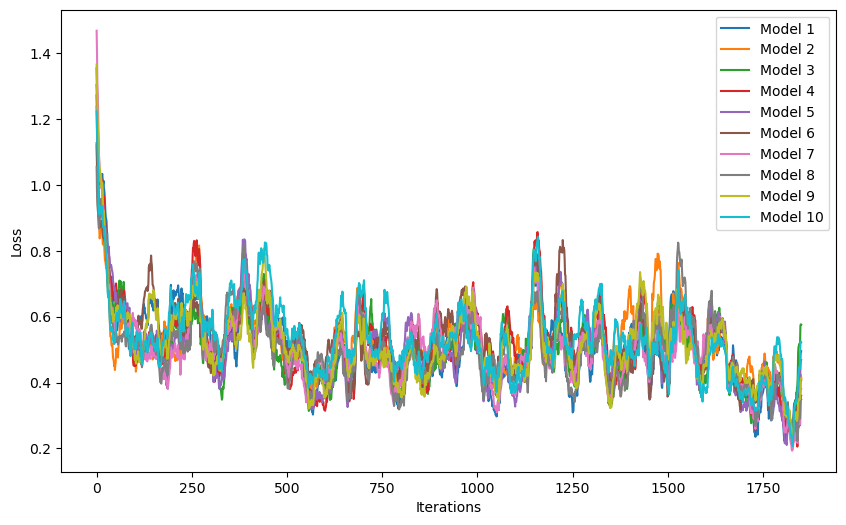

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def moving_average(data, window_size=25):
    return torch.tensor([torch.mean(data[i:i+window_size]) for i in range(len(data) - window_size + 1)])


smoothed_losses_all = [moving_average(torch.tensor(losses), window_size=25) for losses in losses_all]

plt.figure(figsize=(10, 6))


for i, smoothed_losses in enumerate(smoothed_losses_all):
    plt.plot(smoothed_losses.detach().numpy(), label=f'Model {i+1}')

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()



# Evaluation

## Task 3a) (20 P)

In this task we will compare the overall accuracy of our models. The accuracy is defined as follows:

\begin{equation} \text{accuracy } = \frac{\text{\# correctly classified samples}}{\text{\# samples}} \end{equation}

Complete the missing part of the following function that gets as input a model and a dataloader and outputs the accuracy metric.

In [ ]:
def compute_accuracy(model: nn.Module, dataloader: DataLoader) -> float:
    "Compute accuracy of `model` on the dataset in `dataloader`."
    n_correctly_classified = 0

    for batch, labels in dataloader:

        # --------------------------------------------------
        # TODO: Replace by your code
        # --------------------------------------------------
        # n_correctly_classified += solution_3a_compute_accuracy(
        #    model, batch, labels)
        pred = model(batch)
        
        
        
        value, index = torch.max(pred, dim = 1)
        #print(index.shape)
        n_correctly_classified += (index == labels).sum().item()
        
        # --------------------------------------------------

    accuracy = n_correctly_classified / len(dataloader.dataset)
    return accuracy

In [ ]:
test_accuracies = [compute_accuracy(model, test_loader) for model in models]

for i, test_acc in enumerate(test_accuracies):
    print(f"Model {i+1} Test accuracy: {test_acc:.4f}")

Model 1 Test accuracy: 0.8613
Model 2 Test accuracy: 0.8936
Model 3 Test accuracy: 0.8630
Model 4 Test accuracy: 0.8889
Model 5 Test accuracy: 0.8835
Model 6 Test accuracy: 0.8786
Model 7 Test accuracy: 0.8956
Model 8 Test accuracy: 0.9095
Model 9 Test accuracy: 0.8692
Model 10 Test accuracy: 0.8864


## Task 3b) (20 P)

Next we will take a look at the accuracy the models achieve per class. Write a function, similar to the one in the previous task, that computes the accuracy for a model on a dataset, for each class in the MNIST dataset. The output of that function should be a Python dictionary, that has as keys the integers 0-9 (classes of the MNIST dataset), and as values the corresponding accuracy. The per class accuracy is computed as follows:

\begin{equation} \text{accuracy}_i = \frac{\text{\# correctly classified samples of class } i}{\text{\# samples of class } i} \end{equation}

In [ ]:
def compute_accuracy_per_class(model: nn.Module,
                               dataloader: DataLoader) -> dict[int, float]:
    "Compute the accuracy of `model` for each class of the dataset in `dataloader`."

    # --------------------------------------------------
    # TODO: Replace by your code
    # --------------------------------------------------
    #return solution_3b_accuracy_per_class(model, dataloader)
    
    correct_per_class = torch.zeros(10) 
    total_per_class = torch.zeros(10)

    for batch, labels in dataloader:
        outputs = model(batch)
        value, index = torch.max(outputs, 1)
        
        for i in range(10):
            correct_per_class[i] += ((index == labels) & (labels == i)).sum().item()
            total_per_class[i] += (labels == i).sum().item()
        
    

    accuracy_per_class = {i: (correct_per_class[i] / total_per_class[i]).item()  for i in range(10)}
    return accuracy_per_class
    
    
    # --------------------------------------------------

## Conclusion

Next, there is a function which will plot the accuracy of each model in a bar chart. The x-axis is labelled with the classes, e.g. digits 0-9, and the y-axis corresponds to the accuracy of a given model on that class.

Remember, all 6 models have exactly the same number of parameters, they all have been trained for exactly one epoch on the same ordering of dataset samples, and they have been optimized using the exact same optimizer. Yet, we see significantly different results in terms of class-specific accuracy.

This is due to the highly non-convex loss function, and the random initialization. This causes the models to land in different local optima of the loss function which in turn causes them to perform differently.

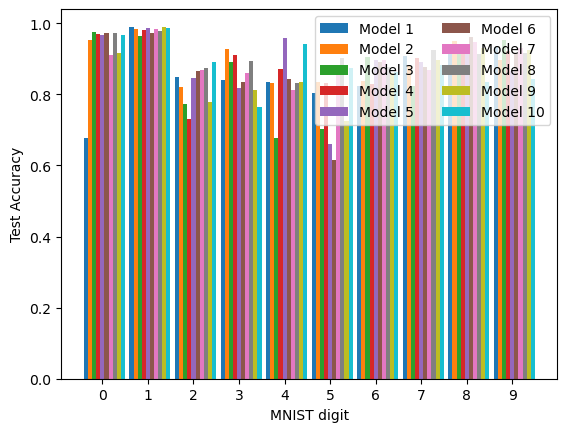

In [ ]:
import matplotlib.pyplot as plt


def accuracies_bar_plot(per_class_accuracies, label):
    labels = list(range(10))

    bar_heights = {
        f"Model {i+1}": list(per_class_accuracies[i].values())
        for i, model in enumerate(models)
    }

    width = 0.09
    multiplier = -3

    for model_id, accuracies in bar_heights.items():
        offset = width * multiplier
        rects = plt.bar([l + offset for l in labels],
                        accuracies,
                        width,
                        label=model_id)
        multiplier += 1

    plt.ylabel(label)
    plt.xlabel("MNIST digit")
    plt.xticks([l + width for l in labels], labels)
    plt.legend(loc="upper right", ncols=2)
    plt.show()


test_per_class_accuracies = [
    compute_accuracy_per_class(model, test_loader) for model in models
]

accuracies_bar_plot(test_per_class_accuracies, "Test Accuracy")
